# Assessment of tests with external reverse dependencies

In [ ]:
%matplotlib inline

import sys
print(f'Python {sys.version}')

import IPython
print(f'IPython {IPython.__version__}')

print('\nLibraries:\n')

import matplotlib
import matplotlib.pyplot as plt
print(f'matplotlib {matplotlib.__version__}')

import numpy as np
print(f'numpy {np.__version__}')

import pandas as pd
from pandas.plotting import register_matplotlib_converters
print(f'pandas {pd.__version__}')

import requests
print(f'requests {requests.__version__}')

Python 3.7.4 (default, Jul  8 2019, 18:31:06) 
[GCC 7.4.0]
IPython 7.6.1

Libraries:

matplotlib 3.1.1
numpy 1.17.0
pandas 0.25.0
requests 2.22.0


In [ ]:
plt.rcParams.update({
    'figure.figsize': [7, 10],
    'xtick.labelsize': 7,
    'ytick.labelsize': 7,
    'legend.fontsize': 7,
    'axes.titlesize': 8,
    'legend.frameon': True,
    'savefig.bbox': 'tight',
    'savefig.pad_inches': 0.05,
    'lines.linewidth': 1,
    'figure.dpi': 300.0
})

register_matplotlib_converters()

## Fetching the commit status data

We fetch all the pull requests since #9288, which is the first one to be opened after [#9278](https://github.com/coq/coq/pull/9278) was merged. The latter introduced the distinction between "plugins" and "libraries" in the names of the CI jobs.

In [ ]:
api_token = ''

def send_graphql_request(query, variables):
    headers = {'Authorization': f'token {api_token}'}
    url = 'https://api.github.com/graphql'
    json = {'query':query, 'variables':variables}
    r = requests.post(url=url, json=json, headers=headers)
    r.raise_for_status() # Abort if unsuccessful request
    return r.json()

In [ ]:
query = '''
query getCommitStatus($cursor: String) {
  repository(owner: "coq", name: "coq") {
    pullRequests(first: 50, after: $cursor, baseRefName: "master", orderBy: {field: CREATED_AT, direction: DESC}) {
      pageInfo { endCursor }
      nodes {
        number
        merged
        commits(first: 100) {
          totalCount
          nodes {
            commit {
              ... commit
            }
          }
        }
        timelineItems(last: 100, itemTypes: [HEAD_REF_FORCE_PUSHED_EVENT]) {
          totalCount
          nodes {
            ... on HeadRefForcePushedEvent {
              beforeCommit {
                ... commit
              }
            }
          }
        }
      }
    }
  }
}

fragment commit on Commit {
  abbreviatedOid
  committedDate
  status {
    state
    contexts {
      state
      context
      description
    }
  }
}
'''

In [ ]:
columns = [
    'pull request number',
    'pull request merged',
    'commit date',
    'success', # on GitLab
    'not run', # canceled or force-pushed before completion, or not run because of conflicts with base branch
    'breaks build',
    'breaks test-suite',
    'breaks doc',
    'broken plugins nb',
    'broken libraries nb'
]
values = pd.DataFrame(columns=columns)

def read_commit(commit, number, merged):
    if commit['status'] is not None:
        status = commit['status']['state']
        if status != 'PENDING':
            index = commit['abbreviatedOid']
            values.loc[index, 'pull request number'] = number
            values.loc[index, 'pull request merged'] = merged
            values.loc[index, 'commit date'] = commit['committedDate']
            if status == 'SUCCESS':
                values.loc[index, 'success'] = True
            elif status == 'FAILURE':
                gitlab_failures = 0
                breaks_build = False
                breaks_test_suite = False
                breaks_doc = False
                broken_plugins = 0
                broken_libraries = 0
                for context in commit['status']['contexts']:
                    if context['state'] == 'FAILURE':
                        name = context['context']
                        if 'GitLab' in name or 'GitLab' in context['description']:
                            gitlab_failures += 1
                            if 'build:' in name:
                                breaks_build = True
                            elif 'test-suite:' in name:
                                breaks_test_suite = True
                            elif 'doc:' in name:
                                breaks_doc = True
                            elif 'plugin:' in name:
                                broken_plugins += 1
                            elif 'library:' in name:
                                broken_libraries += 1
                values.loc[index, 'success'] = (gitlab_failures == 0) # The failure comes from Travis / AppVeyor
                values.loc[index, 'not run'] = (gitlab_failures == 1) # No build failure was reported
                values.loc[index, 'breaks build'] = breaks_build
                values.loc[index, 'breaks test-suite'] = breaks_test_suite
                values.loc[index, 'breaks doc'] = breaks_doc
                values.loc[index, 'broken plugins nb'] = broken_plugins
                values.loc[index, 'broken libraries nb'] = broken_libraries
            else:
                raise ValueError(f'Unknown status: {status}!')

def read_result(json):
    pullrequests = json['data']['repository']['pullRequests']
    cursor = pullrequests['pageInfo']['endCursor']
    for pullrequest in pullrequests['nodes']:
        number = pullrequest['number']
        merged = pullrequest['merged']
        if number < 9288:
            raise Exception(f'We reached PR #{number}. We should have stopped before!')
        if pullrequest['commits']['totalCount'] > 100:
            print(f'Warning: PR #{number} has more than 100 commits!')
        if pullrequest['timelineItems']['totalCount'] > 100:
            print(f'Warning: PR #{number} has been force-pushed more than 100 times!')
        for commit in pullrequest['commits']['nodes']:
            read_commit(commit['commit'], number, merged)
        for commit in pullrequest['timelineItems']['nodes']:
            read_commit(commit['beforeCommit'], number, merged)
        if number == 9288:
            print(f'Current PR: #9288. We stop here.')
            return False, cursor # We stop here
    sys.stdout.write(f'Current PR: #{number}\r')
    sys.stdout.flush()
    return True, cursor

keep_going = True
cursor = None
while keep_going:
    json = send_graphql_request(query, {'cursor': cursor})
    keep_going, cursor = read_result(json)

Current PR: #9288. We stop here.


In [ ]:
values.to_csv('commit_status.csv')

## Analyzing the fetched data

The previous section can be skipped if the data is already available as a CSV file.

In [ ]:
builds = pd.read_csv('commit_status.csv', index_col=0, parse_dates=['commit date'])
len(builds)

2646

### Pre-processing: we remove canceled / pending / not-run builds

In [ ]:
builds = builds[builds['not run'] != True]
additional_builds_to_remove = [
    # List obtained by manually verifying the 10 commits that broke both the build and the test-suite
    '4dbb271', 'f0896b9', '32a33a7', 'a6f9a87', '1f03d39', '11e052b', '3e3f92d', '9c28f62',
    # List obtained by manually verifying the 17 commits that broke more than 10 libraries
    # Actually, inspecting only the 8 ones that broke more than 18 libraries would have yield the same results
    '0d13e11', '9a66872', '7b1feee', 'e0c4921', '4ba4aac',
    # Found by looking at merged PRs with a high number of broken libraries or plugins
    '8f5732d', # PR #9999
    'd578525', # PR #9957
    'a249cc9', '1eb1fe7', # PR #9757
]
builds = builds.drop(additional_builds_to_remove)
len(builds)

2392

### Compute the builds order within a same pull request

We sort builds within a same pull request by the commit date.

In [ ]:
pullrequests = builds.groupby('pull request number').agg(
    first_build=('commit date', 'min'),
    last_build=('commit date', 'max'),
    broke_libraries=('broken libraries nb', 'max'),
    nb_builds=('pull request number', 'count')
)
pullrequests = pullrequests.assign(
    duration=pullrequests['last_build']-pullrequests['first_build'],
    pull_request_count=range(1, len(pullrequests) + 1),
    broke_libraries=pullrequests['broke_libraries'] > 0
)

In [ ]:
build_numbers = pd.DataFrame(columns=['build_number'])
for number, pullrequest in pullrequests.iterrows():
    pullrequest_builds = builds[builds['pull request number'] == number].sort_values('commit date')
    pullrequest_builds = pullrequest_builds.assign(
        build_number=range(1, len(pullrequest_builds) + 1),
        pull_request_count=pullrequest['pull_request_count']
    )
    build_numbers = build_numbers.append(pullrequest_builds[['build_number','pull_request_count']], sort=False)
builds = builds.join(build_numbers)

### Proportion of failed builds

The proportion of failed builds is high (more than half):

In [ ]:
failed_builds = builds[~builds['success']]
successful_builds = builds[builds['success']]
len(failed_builds) / len(builds)

0.5263377926421404

The proportion of pull requests whose first build is a failure is slightly smaller:

In [ ]:
first_builds = builds[builds['build_number'] == 1]
failed_first_builds = first_builds[~first_builds['success']]
len(failed_first_builds) / len(first_builds)

0.49175824175824173

### Failure reasons

The reason can be because the build of Coq itself is broken (although developers most often try to compile locally before pushing):

In [ ]:
len(failed_builds[failed_builds['breaks build']]) / len(failed_builds)

0.16679904686258937

This is only slightly higher when considering pull request first builds:

In [ ]:
len(failed_first_builds[failed_first_builds['breaks build']]) / len(failed_first_builds)

0.19832402234636873

Less than 3% of commits breaks both the build and something else. This is because most build test are in the first stage, and the rest of the tests are only run in the second stage, if the first stage succeeded.

In [ ]:
len(failed_builds[
    failed_builds['breaks build'] &
    (failed_builds['breaks test-suite'] |
     failed_builds['breaks doc'] |
     (failed_builds['broken plugins nb'] > 0) |
     (failed_builds['broken libraries nb'] > 0))
]) / len(failed_builds[failed_builds['breaks build']])

0.02857142857142857

The test-suite is broken more frequently (since the introduction of CI, developers do not always run the test-suite locally, and external contributors may not even be aware of it from the start):

In [ ]:
len(failed_builds[failed_builds['breaks test-suite']]) / len(failed_builds)

0.2533756949960286

Again, the proportion is slightly higher when considering pull request first builds. This is despite the fact that build failures are in higher proportions and that the test-suite is not run when there is a build failure.

In [ ]:
len(failed_first_builds[failed_first_builds['breaks test-suite']]) / len(failed_first_builds)

0.26536312849162014

When considering only the builds that passed the build step, a larger proportion failed the test-suite:

In [ ]:
len(failed_builds[
    failed_builds['breaks test-suite'] & (failed_builds['breaks build'] == False)
]) / len(failed_builds[failed_builds['breaks build'] == False])

0.30219256434699715

And this proportion is slightly larger but not that much when considering only pull request first builds:

In [ ]:
len(failed_first_builds[
    failed_first_builds['breaks test-suite'] & (failed_first_builds['breaks build'] == False)
]) / len(failed_first_builds[failed_first_builds['breaks build'] == False])

0.32752613240418116

The culprit is rarely the documentation. Indeed, most pull requests do not update the documentation, and when they do, developers often try to compile locally before pushing.

In [ ]:
len(failed_builds[failed_builds['breaks doc']]) / len(failed_builds)

0.08419380460683082

External plugins are broken very frequently. This happens when developers change the API, but it can also be due to a synchronization issue following the integration of a pull request with overlays, if the overlays take some time to be merged.

In [ ]:
len(failed_builds[failed_builds['broken plugins nb'] > 0]) / len(failed_builds)

0.47736298649722003

Naturally, this is an even higher proportion of builds that passed the build step:

In [ ]:
len(failed_builds[
    (failed_builds['broken plugins nb'] > 0) & (failed_builds['breaks build'] == False)
]) / len(failed_builds[failed_builds['breaks build'] == False])

0.5681601525262154

External libraries are broken less often than plugins, but still account for a large proportion of the broken builds. Synchronization issues generally do not happen with libraries (because overlays can be merged before the main PR), but it happens from time to time that library maintainers are responsible for the breakage.

In [ ]:
len(failed_builds[failed_builds['broken libraries nb'] > 0]) / len(failed_builds)

0.2962668784749801

Naturally, the proportion is higher when counting only builds that passed the build step:

In [ ]:
len(failed_builds[
    (failed_builds['broken libraries nb'] > 0) & (failed_builds['breaks build'] == False)
]) / len(failed_builds[failed_builds['breaks build'] == False])

0.3555767397521449

Considering all the builds of a pull request, about a quarter of all pull requests broke a library at one point or another:

In [ ]:
pullrequests_that_broke_libraries = pullrequests[pullrequests['broke_libraries']]
len(pullrequests_that_broke_libraries) / len(pullrequests)

0.26373626373626374

Other type of failures include specific platforms (typically Windows, which has also sometimes been broken for a few days by a change in Cygwin), a linter failure, or some other rarely broken tests.

In [ ]:
unknown_failures = failed_builds[
    ~(failed_builds['breaks build'] | failed_builds['breaks test-suite'] | failed_builds['breaks doc']) &
    (failed_builds['broken plugins nb'] == 0) &
    (failed_builds['broken libraries nb'] == 0)
]

len(unknown_failures) / len(failed_builds)

0.10405083399523431

The total is well above 100% because some types of failures frequently happen together.

### Failures only caught by the test-suite

Often, the test-suite breakage corresponds to a breakage of the external projects tested in CI. However, it also happens that the test-suite is the only one to break. In most of these cases, the failed tests are some output tests (the test-suite checks that the output of some commands did not change).

In [ ]:
failures_not_caught_by_libraries = failed_builds[
    failed_builds['breaks test-suite'] &
    (failed_builds['broken libraries nb'] == 0)
]

len(failures_not_caught_by_libraries) / len(failed_builds)

0.12629070691024621

This represents about half of the test-suite failures:

In [ ]:
len(failures_not_caught_by_libraries) / len(failed_builds[failed_builds['breaks test-suite']])

0.49843260188087773

### Failures not caught by the test-suite

Each time a library breaks but the test-suite did not, this highlights a shortcoming of the test-suite, and validates the usefulness of our compatibility testing infrastructure. It happens quite often actually! This could be a source for forging new test cases.

In [ ]:
failures_not_caught_by_the_test_suite = failed_builds[
    (failed_builds['breaks test-suite'] == False) &
    (failed_builds['broken libraries nb'] > 0)
]

len(failures_not_caught_by_the_test_suite) / len(failed_builds)

0.1691818903891978

In [ ]:
len(failures_not_caught_by_the_test_suite) / len(failed_builds[failed_builds['broken libraries nb'] > 0])

0.5710455764075067

Sometimes, a single library breakage could be explained by this library being broken by its maintainer (spurious build failure), but when two libraries are broken at the same time, this is much less likely:

In [ ]:
len(failed_builds[
    (failed_builds['breaks test-suite'] == False) &
    (failed_builds['broken libraries nb'] > 1)
]) / len(failed_builds[failed_builds['broken libraries nb'] > 1])

0.4444444444444444

## Visualizing the data

We plot the successful builds after having plotted the failed builds. The consequence is that if a failed build was quickly fixed, given the time scale, we will only see a green dot.

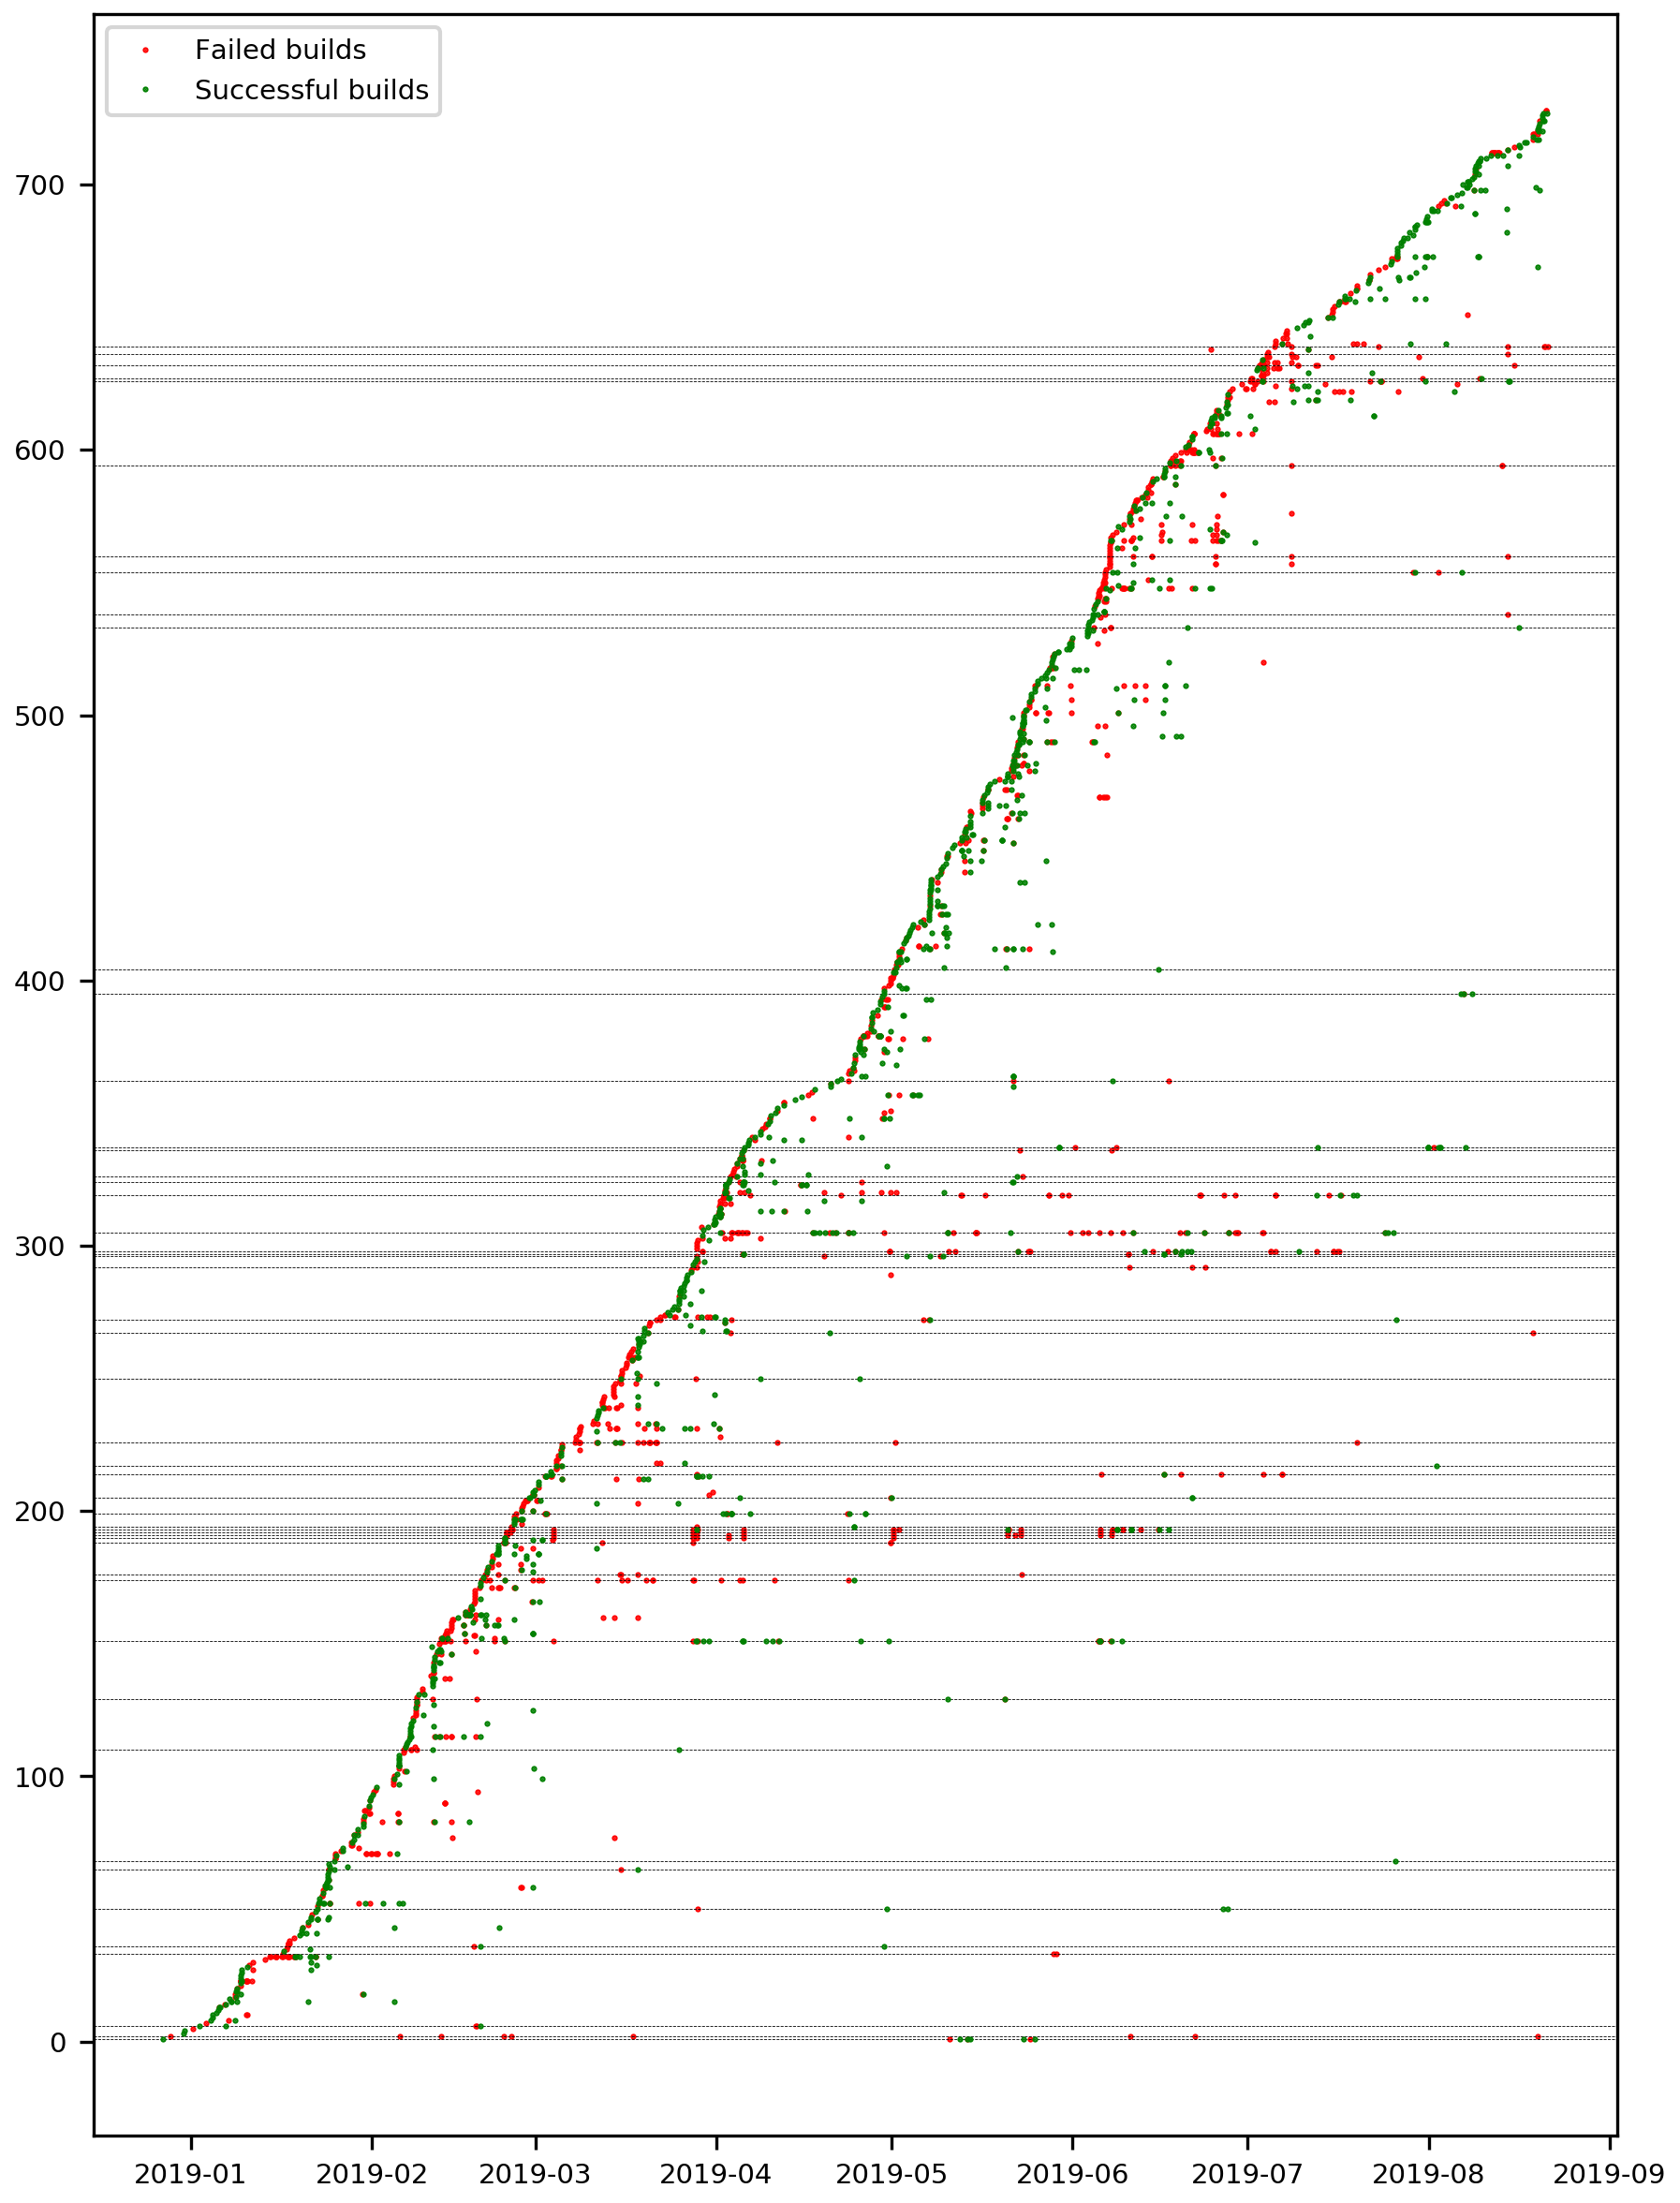

In [ ]:
plt.plot(failed_builds['commit date'], failed_builds['pull_request_count'],'.',markersize=1,color='red',label='Failed builds')
for _, pullrequest in pullrequests.sort_values('duration', ascending=False)[:50].iterrows():
    plt.axhline(y=pullrequest['pull_request_count'], color='black',lw=0.2,linestyle='--')
plt.plot(successful_builds['commit date'], successful_builds['pull_request_count'],'.',markersize=1,color='green',label='Successful builds')
plt.legend()
plt.show()

Now we prepare an alternative visualization where the date is replaced by the build number (in the pull request).

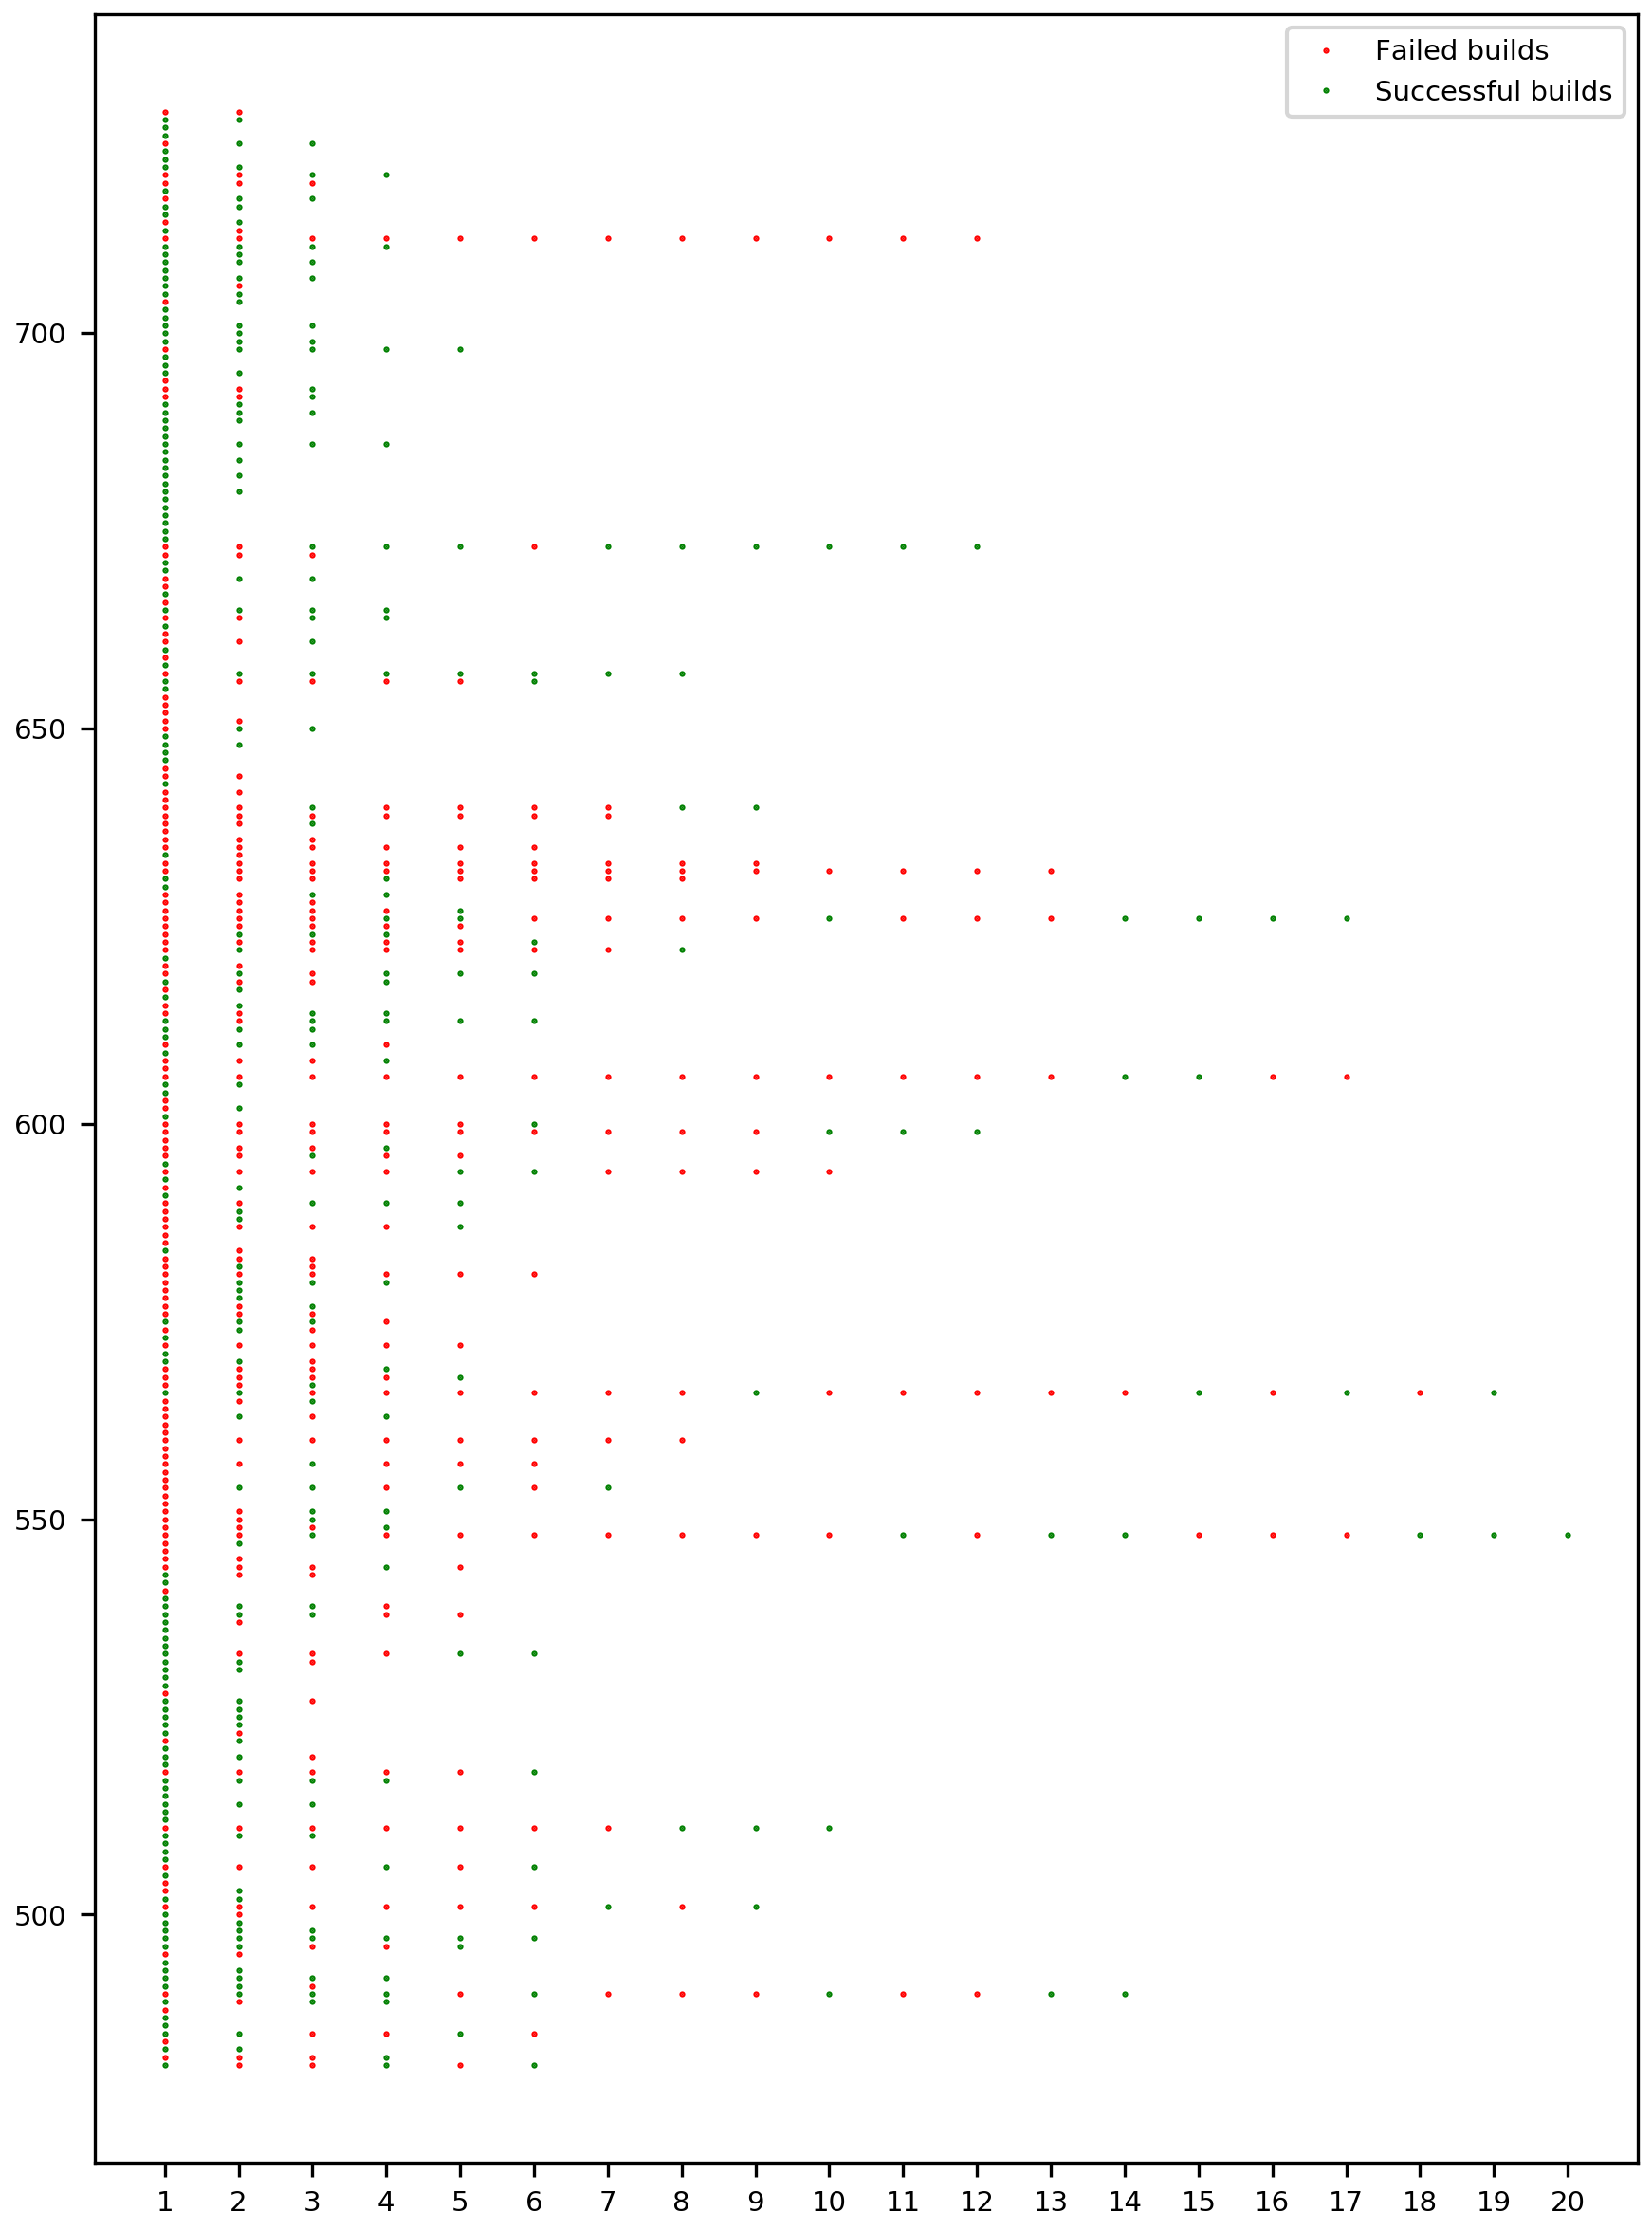

In [ ]:
def local():
    successes = builds[builds['success'] & (builds['pull request number'] >= 10200)]
    failures = builds[~builds['success'] & (builds['pull request number'] >= 10200)]
    plt.plot(failures['build_number'], failures['pull_request_count'],'.',markersize=1,color='red',label='Failed builds')
    plt.plot(successes['build_number'], successes['pull_request_count'],'.',markersize=1,color='green',label='Successful builds')
    plt.legend()
    plt.xticks(range(1,21))
    plt.show()

local()

And now, only for pull requests that broke libraries:

In [ ]:
pullrequests_that_broke_libraries = pullrequests_that_broke_libraries.assign(
    pull_request_count=range(1, len(pullrequests_that_broke_libraries) + 1)
)

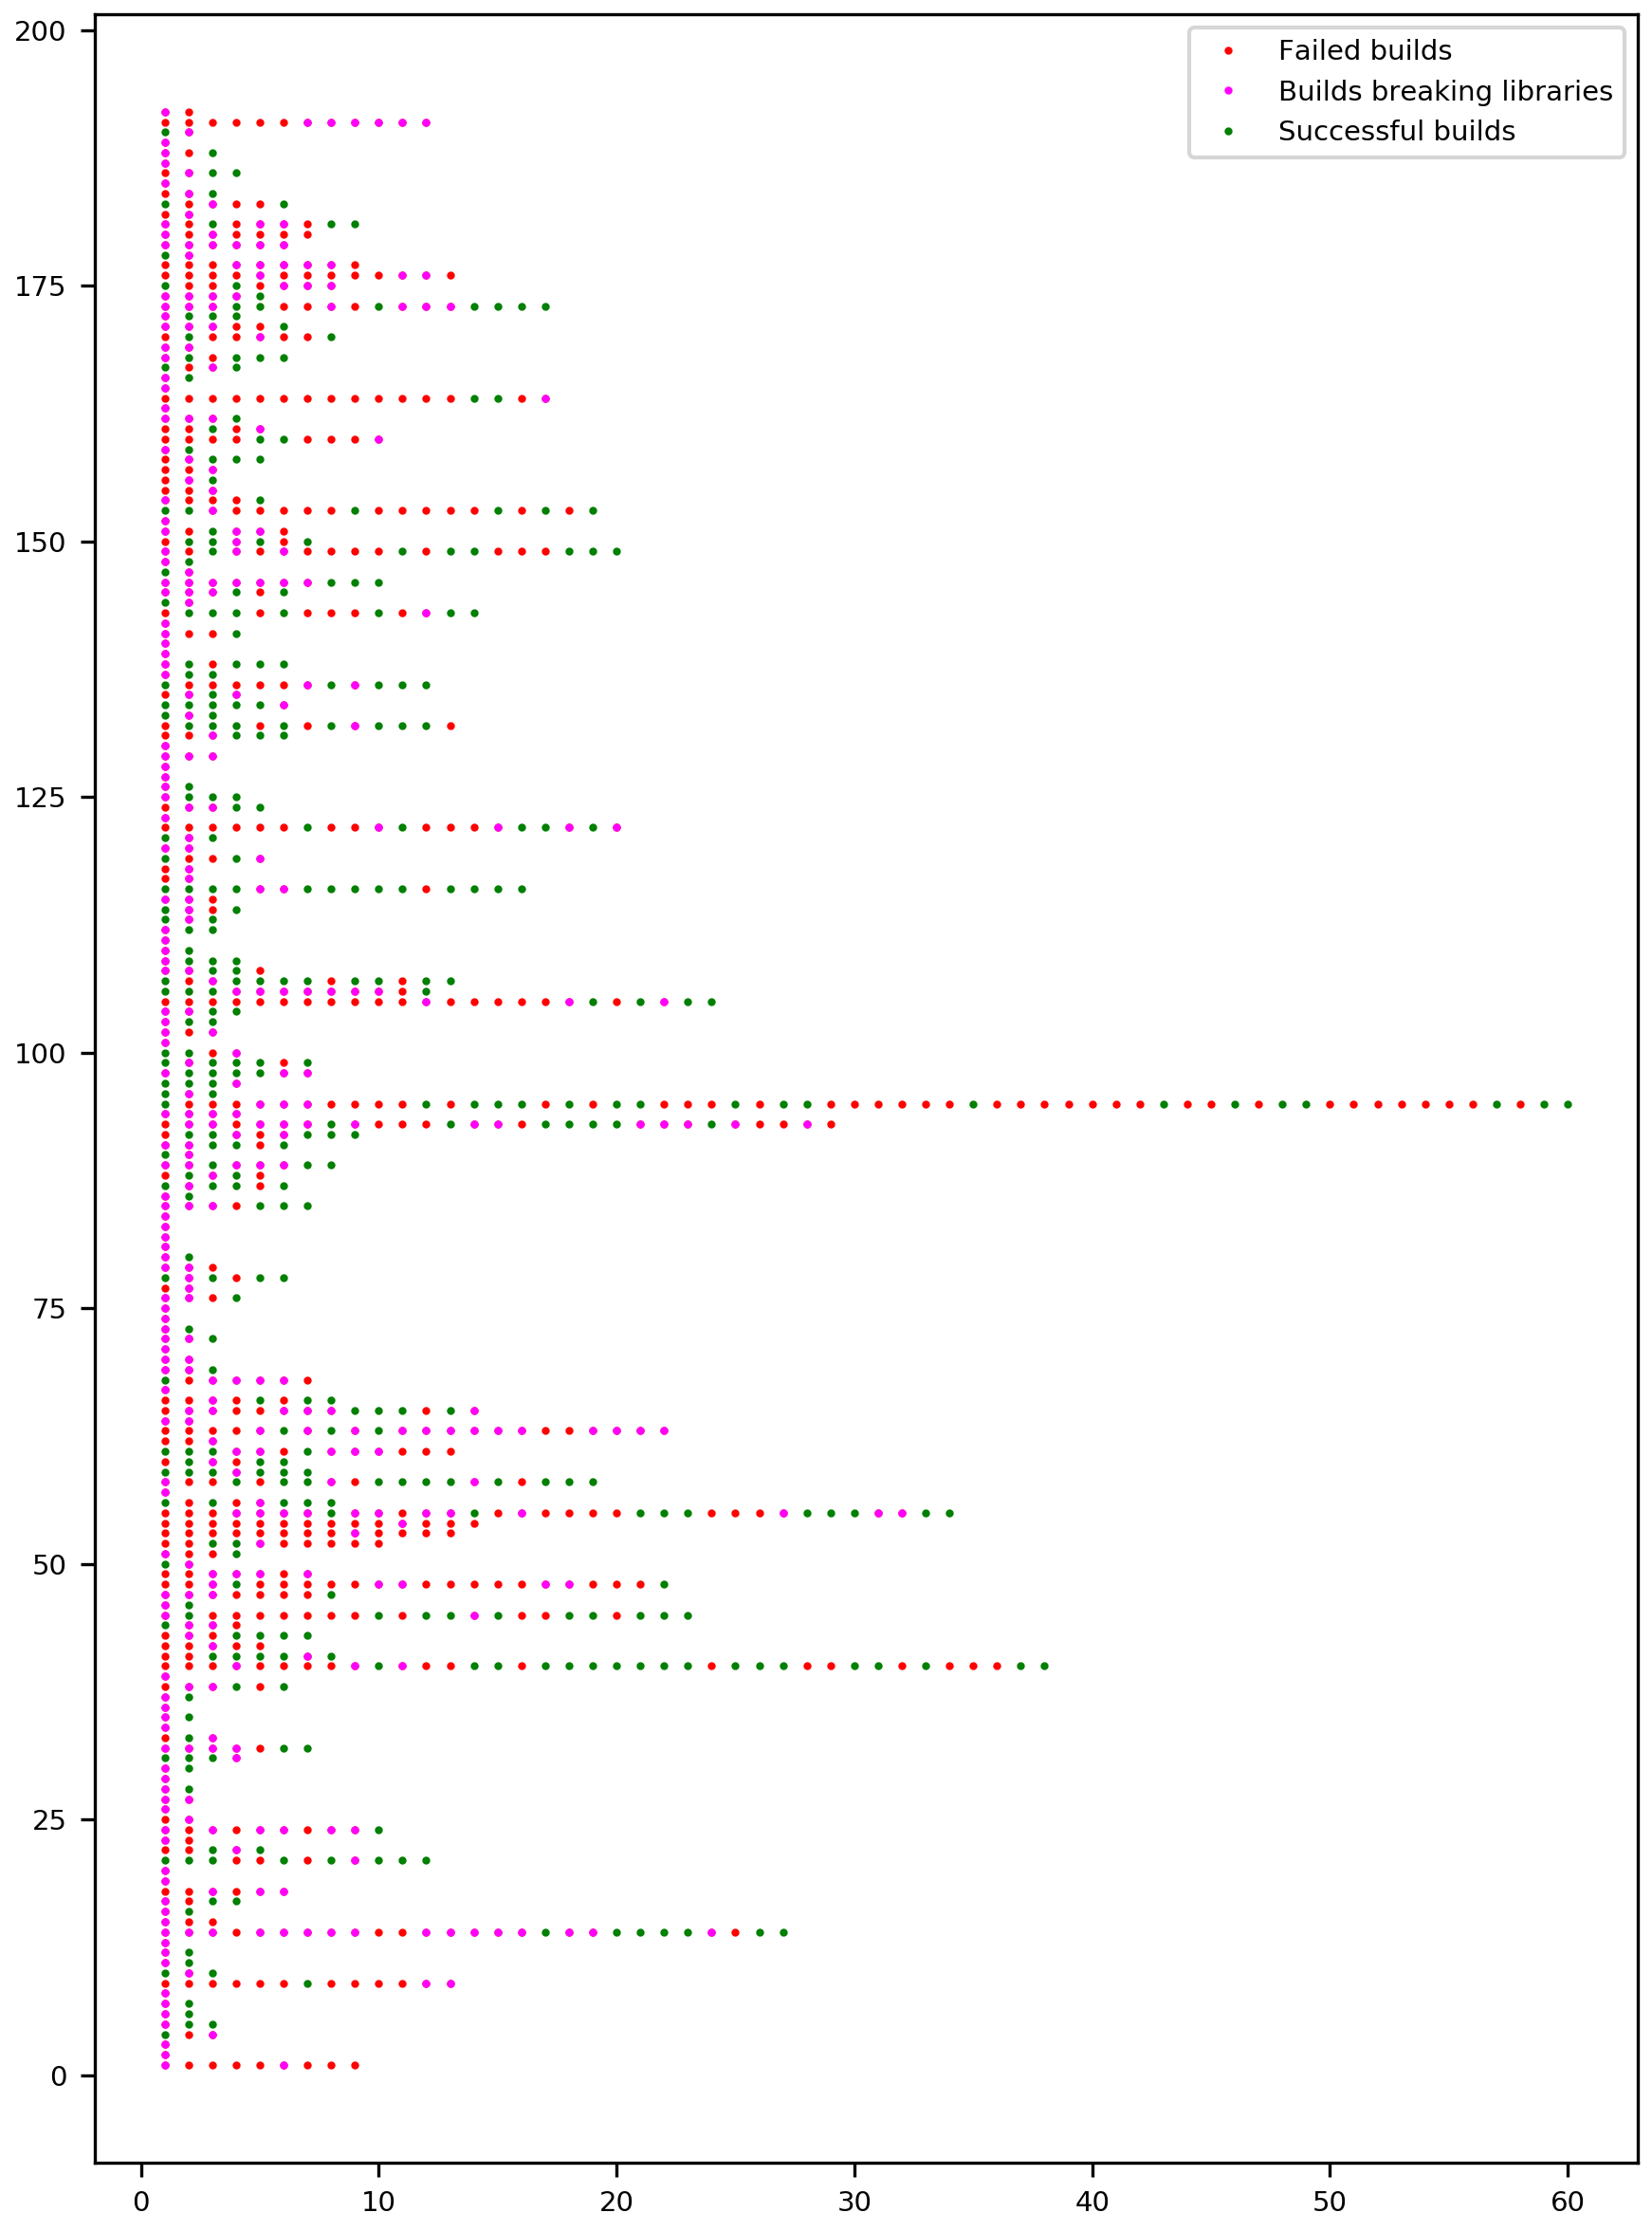

In [ ]:
def plot_helper(data, color, label):
    plt.plot(
        data['build_number'],
        pullrequests_that_broke_libraries.loc[data['pull request number'], 'pull_request_count'],
        '.',
        markersize=2,
        color=color,
        label=label
    )

def local():
    my_builds = builds[builds['pull request number'].isin(pullrequests_that_broke_libraries.index)]    
    failures = my_builds[~my_builds['success']]
    plot_helper(failures, 'red', 'Failed builds')
    plot_helper(failures[failures['broken libraries nb'] > 0], 'magenta', 'Builds breaking libraries')
    plot_helper(my_builds[my_builds['success']], 'green', 'Successful builds')
    plt.legend()
    plt.show()

local()

### Proportion of spurious failures

In [ ]:
last_builds = builds.sort_values(
    'build_number',
    ascending=False
).drop_duplicates(['pull request number']).set_index('pull request number').sort_index()

The proportion of pull requests having been merged despite the last build being failed is quite high. This is a way of estimating spurious failures (such as synchronization issues, broken libraries, etc.).

In [ ]:
spurious_failures = last_builds[~last_builds['success'] & last_builds['pull request merged']]
len(spurious_failures) / len(last_builds['pull request merged'])

0.18406593406593408

Out of these spurious failures, almost half are due to broken plugins (likely because of synchronization issues):

In [ ]:
spurious_plugin_failures = spurious_failures[spurious_failures['broken plugins nb'] > 0]
len(spurious_plugin_failures) / len(spurious_failures)

0.4552238805970149

In more than 30% of the time, this is due to several plugins at once (typical when the builds happen just after a PR was merged and plugin maintainers have no reacted yet):

In [ ]:
spurious_plugin_failures['broken plugins nb'].quantile([.65, .7, 1])

0.65    1.0
0.70    2.0
1.00    4.0
Name: broken plugins nb, dtype: float64

In [ ]:
spurious_failures[spurious_failures['broken plugins nb'] > 2]

,pull request merged,commit date,success,not run,breaks build,breaks test-suite,breaks doc,broken plugins nb,broken libraries nb,build_number,pull_request_count
pull request number,,,,,,,,,,,
9853,True,2019-03-28 13:44:34+00:00,False,False,False,False,False,4.0,0.0,2,295.0
9858,True,2019-03-28 15:43:08+00:00,False,False,False,False,False,3.0,0.0,1,299.0
9859,True,2019-03-28 15:50:25+00:00,False,False,False,False,False,3.0,0.0,1,300.0
9860,True,2019-03-28 16:18:25+00:00,False,False,False,False,False,3.0,0.0,1,301.0
10310,True,2019-06-05 12:32:41+00:00,False,False,False,False,False,3.0,0.0,2,545.0
10311,True,2019-06-05 09:12:24+00:00,False,False,False,False,False,3.0,0.0,1,546.0


A smaller proportion are due to broken libraries:

In [ ]:
spurious_library_failures = spurious_failures[spurious_failures['broken libraries nb'] > 0]
len(spurious_library_failures) / len(spurious_failures)

0.27611940298507465

This is almost always due to a single library:

In [ ]:
spurious_library_failures['broken libraries nb'].quantile([.88, 1])

0.88    1.0
1.00    4.0
Name: broken libraries nb, dtype: float64

Out of the 4 cases with two or more broken libraries, two are due to SSReflect (a shared dependency of 4 libraries and 1 plugin) being broken, and one is due to a commit being incorrectly identified as the last one of the PR.

In [ ]:
spurious_failures[spurious_failures['broken libraries nb'] > 1]

,pull request merged,commit date,success,not run,breaks build,breaks test-suite,breaks doc,broken plugins nb,broken libraries nb,build_number,pull_request_count
pull request number,,,,,,,,,,,
9875,True,2019-04-01 19:24:38+00:00,False,False,False,False,False,0.0,2.0,7,312.0
9881,True,2019-04-03 10:01:25+00:00,False,False,False,False,False,1.0,4.0,3,316.0
9901,True,2019-04-04 00:23:40+00:00,False,False,False,False,False,1.0,4.0,1,329.0
10442,True,2019-06-27 20:50:21+00:00,False,False,False,True,False,0.0,3.0,2,620.0


An even smaller proportion are due to spurious failures in the test-suite:

In [ ]:
len(spurious_failures[spurious_failures['breaks test-suite']]) / len(spurious_failures)

0.1417910447761194

An even smaller proportion are due to spurious failures of the build:

In [ ]:
len(spurious_failures[spurious_failures['breaks build']]) / len(spurious_failures)

0.08208955223880597

Almost none are due to spurious failures in the documentation build:

In [ ]:
len(spurious_failures[spurious_failures['breaks doc']]) / len(spurious_failures)

0.007462686567164179

Finally, other types of spurious failures are also relatively frequent (about as frequent as spurious failures in the test-suite):

In [ ]:
len(spurious_failures[
    ~(spurious_failures['breaks build'] | spurious_failures['breaks doc'] | spurious_failures['breaks test-suite']) &
    (spurious_failures['broken plugins nb'] == 0) &
    (spurious_failures['broken libraries nb'] == 0)
]) / len(spurious_failures)

0.13432835820895522

The total is a bit above 100% because sometimes multiple spurious failures happen simultaneously.